In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

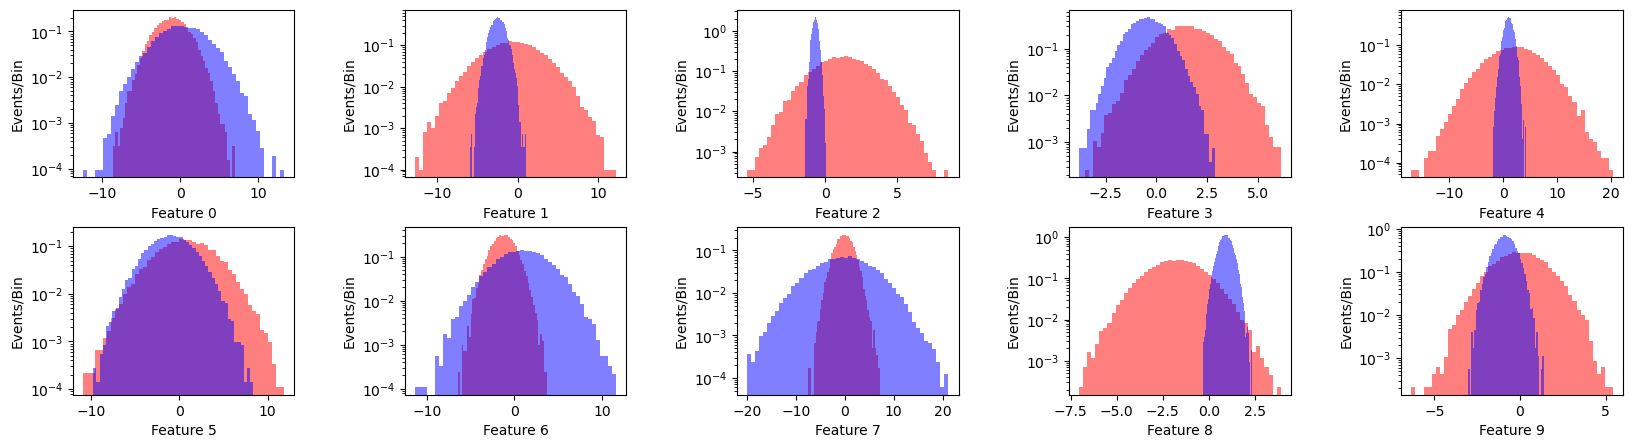

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, gt, lt,
              gt, lt, lt, lt, gt]

In [9]:
# some hyperparameters
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=50
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
target_efficiency = 0.8

In [10]:
net = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
torch.save(net.state_dict(), 'net_learningbiases.pth')
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
{n: theta.shape for n, theta in net.named_parameters()}

{'bias': torch.Size([10])}

In [11]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m, net, target_efficiency, alpha, beta, gamma)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss =loss_fn(y_pred, y_test_tensor, m, net, target_efficiency, alpha, beta, gamma)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    bias=net.bias[0]
    weight=net.weight[0]
    #weight={weight:4.1e}, bias={bias:4.1e}, 
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*test_loss.signaleffic:4.1f}%, bkg_eff={100*test_loss.backgreffic:6.3f}%")

Completed epoch  0 in  0.5s, Train loss=6.1e+00, Test loss=6.1e+00, cut=6.5e-02, sig_eff= 1.8%, bkg_eff= 0.000%
Completed epoch  1 in  0.5s, Train loss=6.0e+00, Test loss=5.9e+00, cut=1.6e-01, sig_eff= 3.0%, bkg_eff= 0.000%
Completed epoch  2 in  0.6s, Train loss=5.6e+00, Test loss=5.6e+00, cut=3.0e-01, sig_eff= 5.4%, bkg_eff= 0.000%
Completed epoch  3 in  0.5s, Train loss=4.9e+00, Test loss=4.8e+00, cut=4.8e-01, sig_eff=10.4%, bkg_eff= 0.002%
Completed epoch  4 in  0.6s, Train loss=3.7e+00, Test loss=3.6e+00, cut=7.1e-01, sig_eff=20.0%, bkg_eff= 0.105%
Completed epoch  5 in  0.5s, Train loss=2.4e+00, Test loss=2.3e+00, cut=9.3e-01, sig_eff=32.9%, bkg_eff= 1.051%
Completed epoch  6 in  0.5s, Train loss=1.4e+00, Test loss=1.5e+00, cut=1.1e+00, sig_eff=43.1%, bkg_eff= 1.525%
Completed epoch  7 in  0.6s, Train loss=1.0e+00, Test loss=9.8e-01, cut=1.2e+00, sig_eff=50.9%, bkg_eff= 1.347%
Completed epoch  8 in  0.5s, Train loss=6.3e-01, Test loss=6.8e-01, cut=1.3e+00, sig_eff=56.4%, bkg_eff=

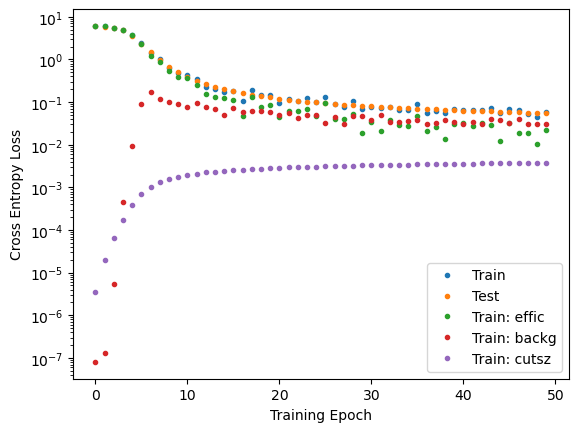

In [12]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

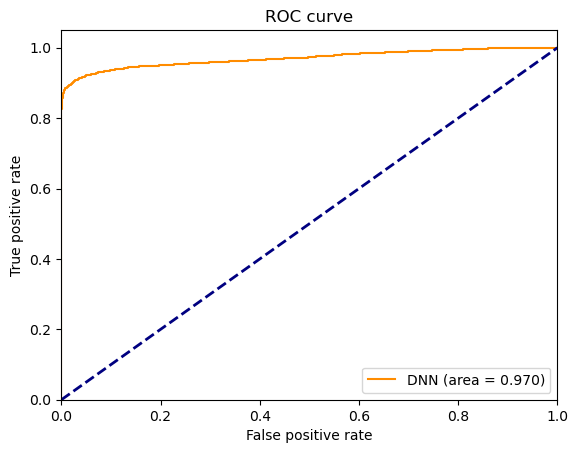

In [13]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = net(x_test_tensor).detach().cpu()
y_pred_train= net(x_train_tensor).detach().cpu()

LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)

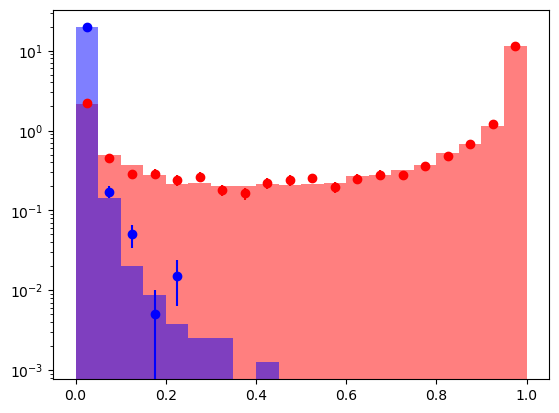

In [14]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

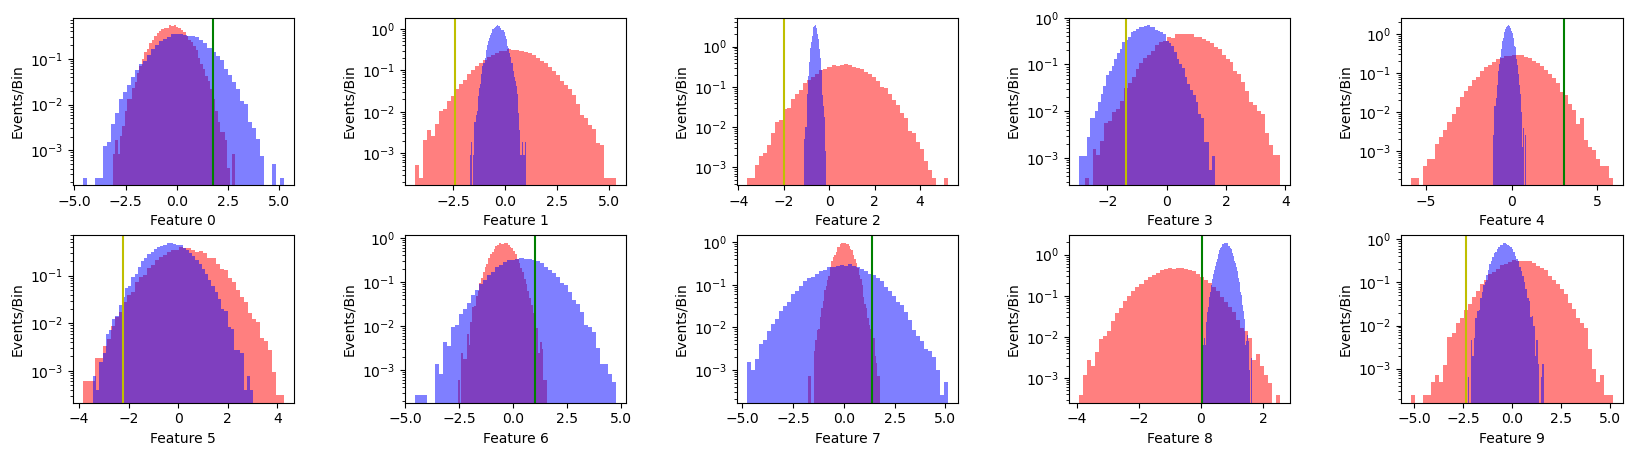

In [15]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

#biases=net.bias.detach().numpy()
weights=net.weight.detach().numpy()
#scaled_cuts=-biases/weights
scaled_cuts=net.get_cuts().detach().numpy()

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"

In [16]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net.apply_cuts(x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Signal Efficiency with net outputs: 77.7%
Background Efficiency with net outputs: 0.00000%


# Use Efficiency Scan Network, 1 target

In [17]:
targeteffics=[0.8]
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=50
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=0   # how much to penalize deviations

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget.pth')
# some hyperparameters
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [18]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.7s, Train loss=6.1e+00, Test loss=6.1e+00
Completed epoch  1 in  0.5s, Train loss=6.0e+00, Test loss=5.9e+00
Completed epoch  2 in  0.5s, Train loss=5.6e+00, Test loss=5.6e+00
Completed epoch  3 in  0.7s, Train loss=4.9e+00, Test loss=4.8e+00
Completed epoch  4 in  0.5s, Train loss=3.7e+00, Test loss=3.6e+00
Completed epoch  5 in  0.5s, Train loss=2.4e+00, Test loss=2.3e+00
Completed epoch  6 in  0.7s, Train loss=1.4e+00, Test loss=1.5e+00
Completed epoch  7 in  0.5s, Train loss=1.0e+00, Test loss=9.8e-01
Completed epoch  8 in  0.5s, Train loss=6.3e-01, Test loss=6.8e-01
Completed epoch  9 in  0.7s, Train loss=4.8e-01, Test loss=5.0e-01
Completed epoch 10 in  0.5s, Train loss=4.4e-01, Test loss=3.9e-01
Completed epoch 11 in  0.7s, Train loss=3.6e-01, Test loss=3.2e-01
Completed epoch 12 in  0.5s, Train loss=2.3e-01, Test loss=2.7e-01
Completed epoch 13 in  0.5s, Train loss=2.0e-01, Test loss=2.3e-01
Completed epoch 14 in  0.6s, Train loss=1.8e-01, Test loss=2.0

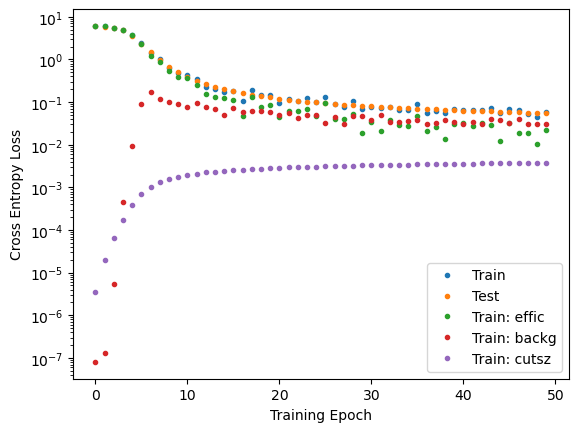

In [19]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

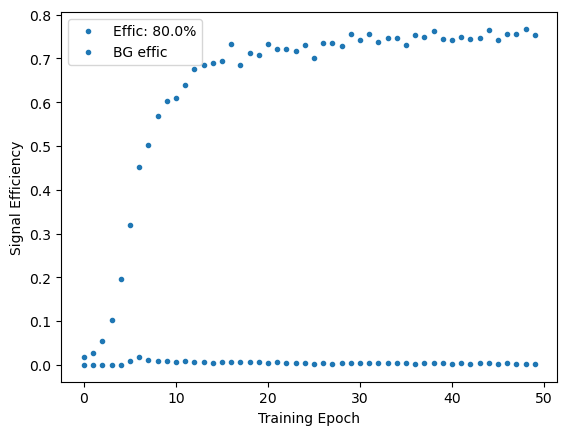

In [20]:
LearningCutsUtils.LearningCutsUtils.ploteffics(losses, targeteffics)

Target efficiency: 80.0%
[ 1.7609888  -2.4474695  -1.9856234  -1.3920859   3.0721748  -2.231913
  1.0174793   1.3820785   0.01928601 -2.354884  ]


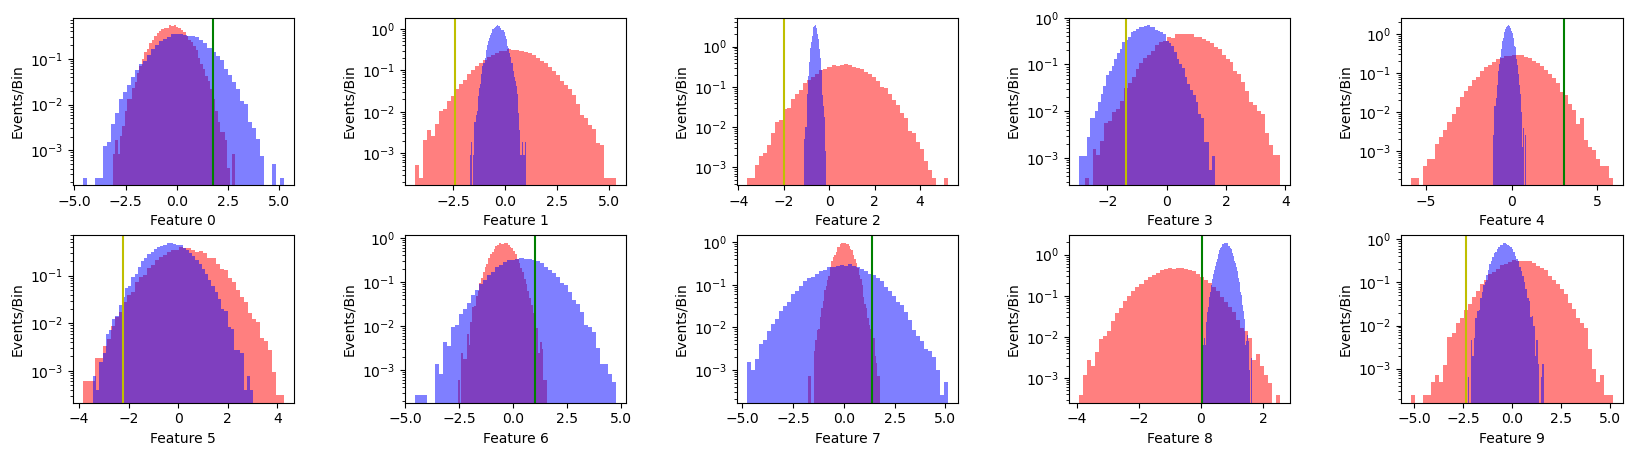

In [21]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    #biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    #scaled_cuts=-biases/weights
    scaled_cuts=net.nets[n].get_cuts().detach().numpy()
    print(scaled_cuts)
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()

In [22]:
LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net.nets[0],True)

Signal Efficiency with net outputs: 77.7%
Background Efficiency with net outputs: 0.00000%


# Multiple Efficiency targets

In [23]:
targeteffics=[0.6,0.7,0.8,0.9]

# some hyperparameters
activation_input_scale_factor=8
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=1.     # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations

## Training all in one go

In [24]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget_untrained.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [25]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

torch.save(net.state_dict(), 'net_learningbiases_effictarget_trained.pth')

Completed epoch  0 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  1 in  0.6s, Train loss=2.2e+01, Test loss=2.1e+01
Completed epoch  2 in  0.8s, Train loss=2.1e+01, Test loss=2.0e+01
Completed epoch  3 in  0.8s, Train loss=2.0e+01, Test loss=1.7e+01
Completed epoch  4 in  0.7s, Train loss=1.7e+01, Test loss=1.2e+01
Completed epoch  5 in  0.6s, Train loss=1.2e+01, Test loss=6.4e+00
Completed epoch  6 in  0.8s, Train loss=6.5e+00, Test loss=3.1e+00
Completed epoch  7 in  0.8s, Train loss=3.1e+00, Test loss=1.6e+00
Completed epoch  8 in  0.8s, Train loss=1.6e+00, Test loss=1.0e+00
Completed epoch  9 in  0.7s, Train loss=1.0e+00, Test loss=7.3e-01
Completed epoch 10 in  0.7s, Train loss=7.1e-01, Test loss=5.6e-01
Completed epoch 11 in  0.5s, Train loss=5.5e-01, Test loss=4.6e-01
Completed epoch 12 in  0.8s, Train loss=4.4e-01, Test loss=3.8e-01
Completed epoch 13 in  0.7s, Train loss=3.7e-01, Test loss=3.3e-01
Completed epoch 14 in  0.8s, Train loss=3.2e-01, Test loss=2.9

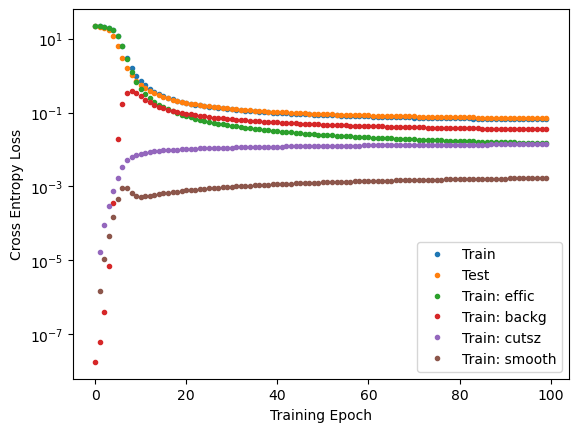

In [26]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

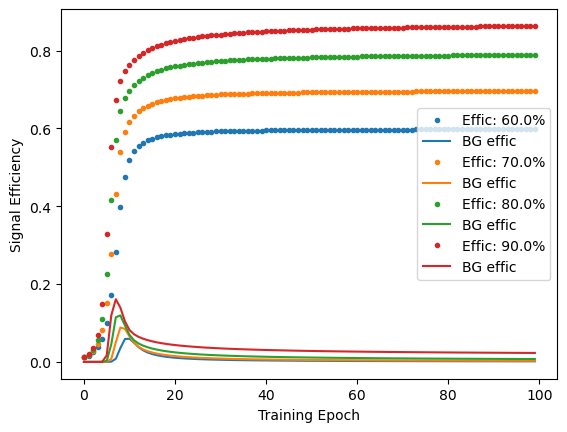

In [27]:
LearningCutsUtils.LearningCutsUtils.ploteffics(losses, targeteffics)

In [28]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor,y_test,net.nets[n],True)

Target efficiency: 60.0%
Signal Efficiency with net outputs: 62.7%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 71.6%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 80.9%
Background Efficiency with net outputs: 0.02509%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 87.5%
Background Efficiency with net outputs: 0.45158%


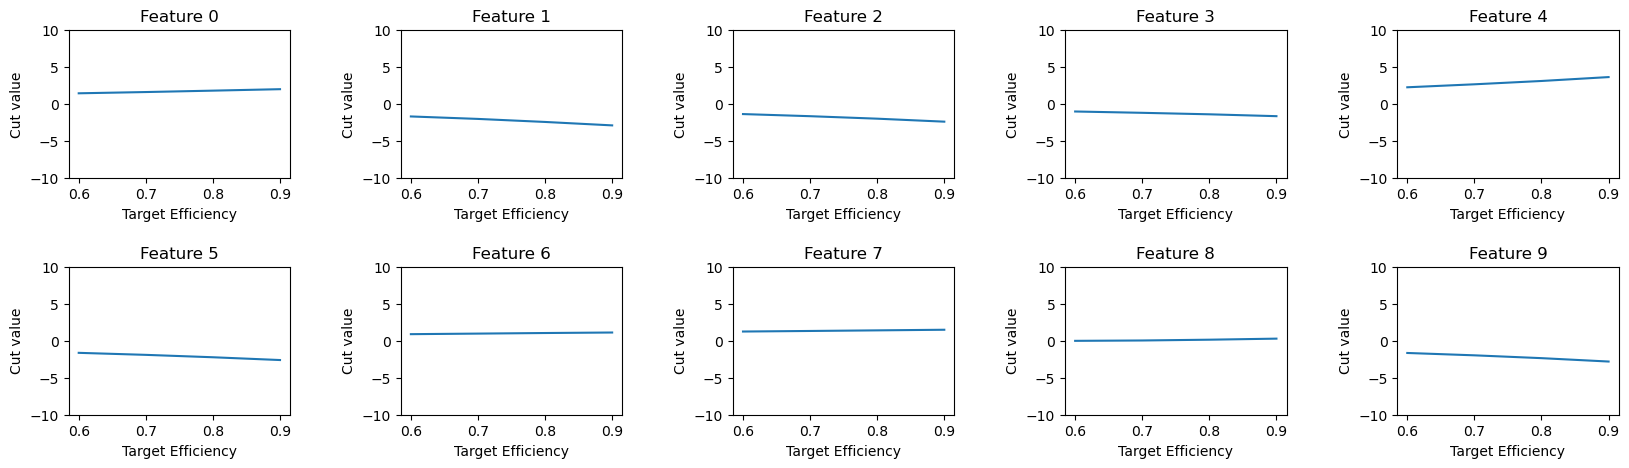

In [29]:
# Distributions of cuts
LearningCutsUtils.LearningCutsUtils.plotcuts(net)

Target efficiency: 60.0%


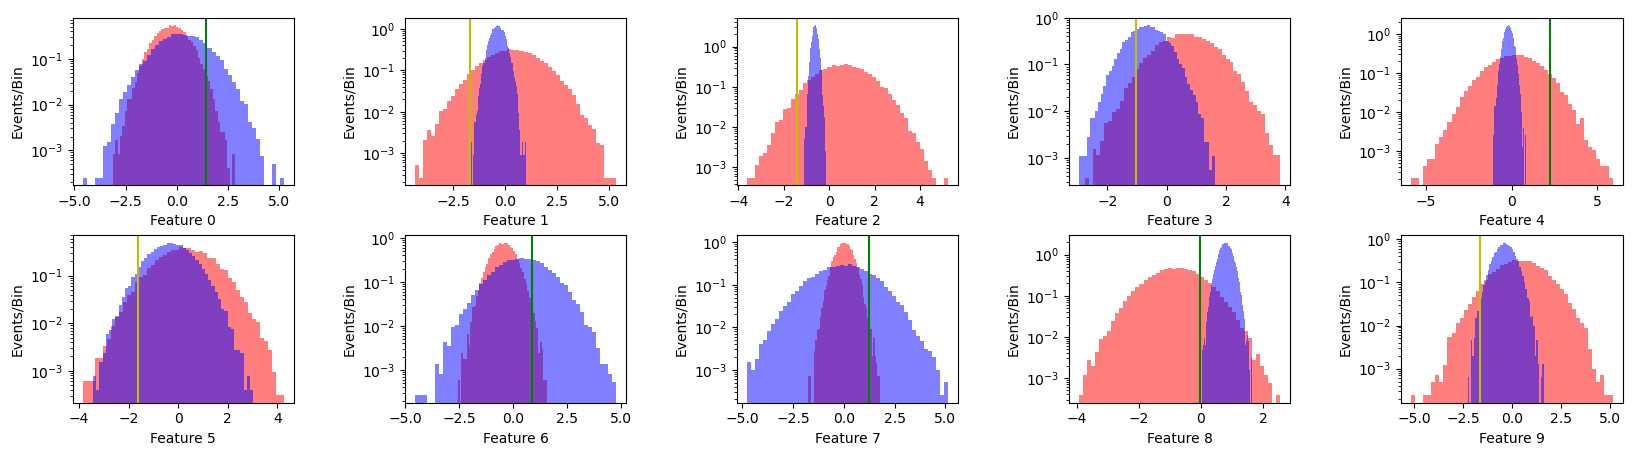

Target efficiency: 70.0%


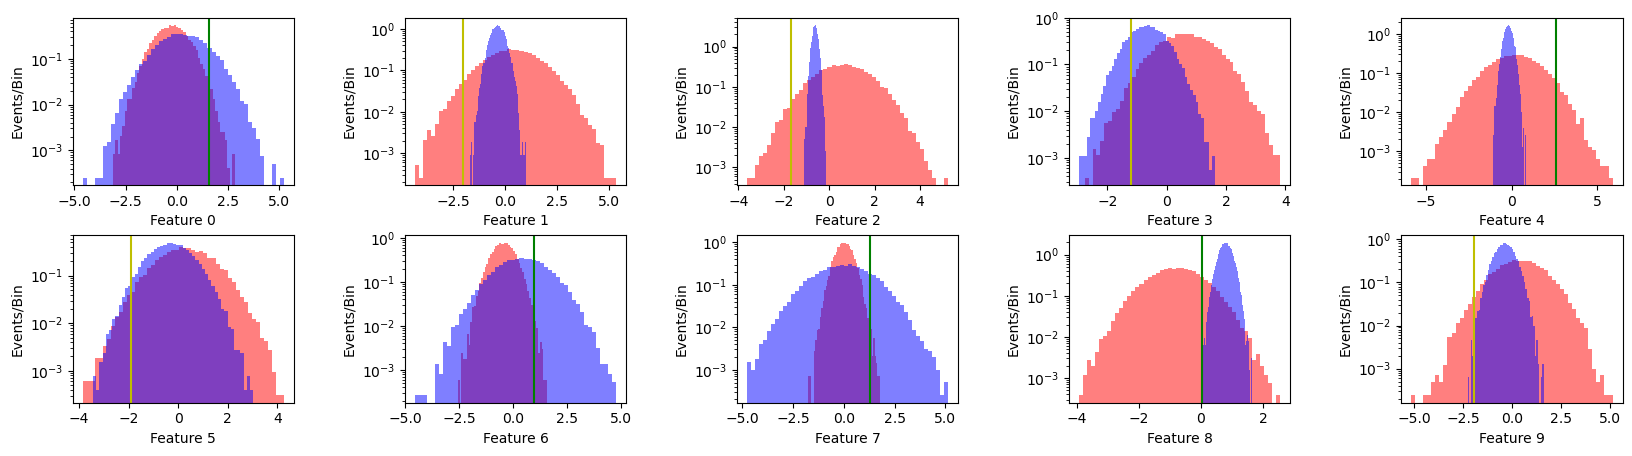

Target efficiency: 80.0%


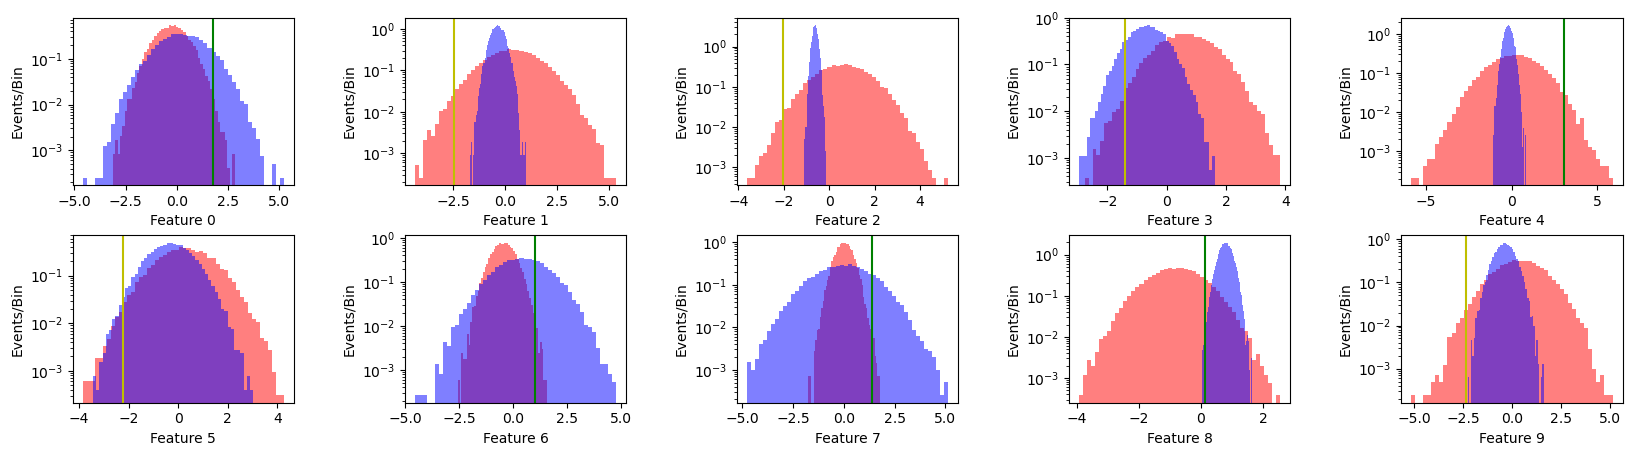

Target efficiency: 90.0%


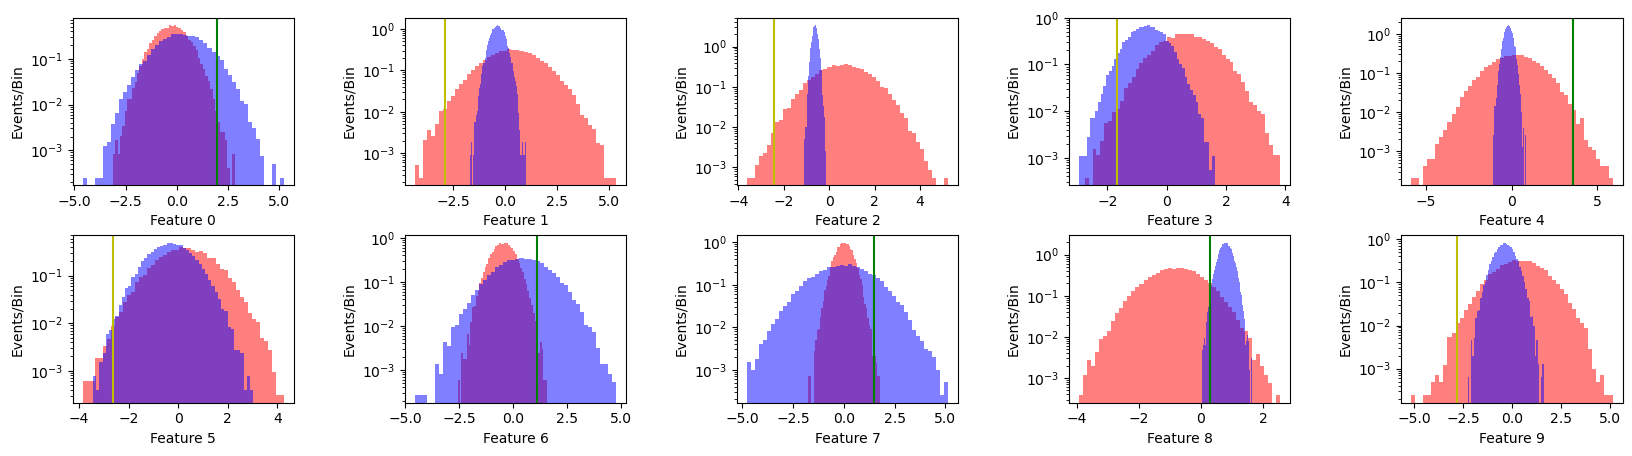

In [30]:
LearningCutsUtils.LearningCutsUtils.plotfeatures(net,x_signal,x_backgr,sc)

## Pre-training for efficiency

Let's see if pre-training for the individual efficiency targets before doing the smoothing helps the algorithm to converge better/faster.

In [31]:
torch.manual_seed(123)

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget_prepretraining.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

Completed epoch  0 in  0.8s, Train loss=3.5e+00, Test loss=3.4e+00
Completed epoch  1 in  0.5s, Train loss=3.4e+00, Test loss=3.3e+00
Completed epoch  2 in  0.7s, Train loss=3.3e+00, Test loss=3.1e+00
Completed epoch  3 in  0.6s, Train loss=3.2e+00, Test loss=2.9e+00
Completed epoch  4 in  0.6s, Train loss=2.9e+00, Test loss=2.4e+00
Completed epoch  5 in  0.7s, Train loss=2.5e+00, Test loss=1.8e+00
Completed epoch  6 in  0.5s, Train loss=1.8e+00, Test loss=9.9e-01
Completed epoch  7 in  0.7s, Train loss=1.0e+00, Test loss=4.4e-01
Completed epoch  8 in  0.7s, Train loss=4.5e-01, Test loss=2.1e-01
Completed epoch  9 in  0.7s, Train loss=2.1e-01, Test loss=1.3e-01
Completed epoch 10 in  0.7s, Train loss=1.3e-01, Test loss=8.6e-02
Completed epoch 11 in  0.7s, Train loss=8.4e-02, Test loss=6.1e-02
Completed epoch 12 in  0.5s, Train loss=6.0e-02, Test loss=4.6e-02
Completed epoch 13 in  0.6s, Train loss=4.5e-02, Test loss=3.6e-02
Completed epoch 14 in  0.7s, Train loss=3.5e-02, Test loss=3.0

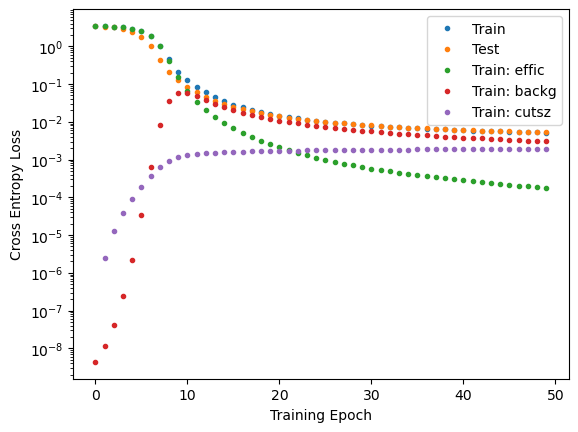

Signal Efficiency with net outputs: 62.2%
Background Efficiency with net outputs: 0.00000%
Parameter containing:
tensor([1.3807, 1.6356, 1.3296, 1.0187, 2.1353, 1.5808, 0.8702, 1.2261, 0.0760,
        1.5892], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.6, subnet_effic=0.5954172611236572, efficloss=0.0002100171404890716
Completed epoch  0 in  0.5s, Train loss=4.7e+00, Test loss=4.7e+00
Completed epoch  1 in  0.7s, Train loss=4.7e+00, Test loss=4.5e+00
Completed epoch  2 in  0.6s, Train loss=4.5e+00, Test loss=4.2e+00
Completed epoch  3 in  0.7s, Train loss=4.3e+00, Test loss=3.8e+00
Completed epoch  4 in  0.7s, Train loss=3.8e+00, Test loss=2.9e+00
Completed epoch  5 in  0.6s, Train loss=3.0e+00, Test loss=1.7e+00
Completed epoch  6 in  0.7s, Train loss=1.8e+00, Test loss=7.6e-01
Completed epoch  7 in  0.4s, Train loss=7.7e-01, Test loss=3.5e-01
Completed epoch  8 in  0.6s, Train loss=3.5e-01, Test loss=2.1e-01
Completed epoch  9 in  0.6s, Train loss=2.0e-01, T

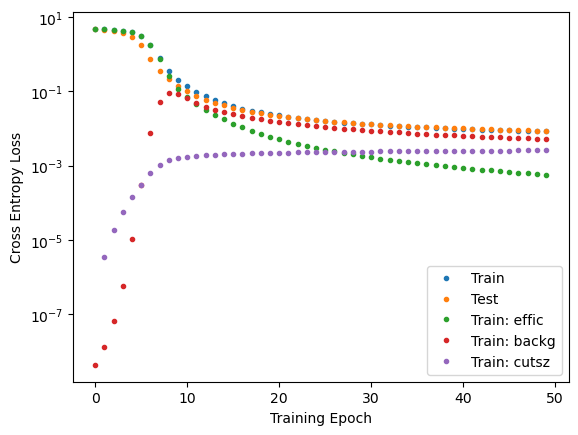

Signal Efficiency with net outputs: 71.2%
Background Efficiency with net outputs: 0.00000%
Parameter containing:
tensor([1.5367, 1.9398, 1.5920, 1.1819, 2.5002, 1.8308, 0.9438, 1.2979, 0.1150,
        1.8774], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.7, subnet_effic=0.6918326020240784, efficloss=0.0006670620059594512
Completed epoch  0 in  0.7s, Train loss=6.2e+00, Test loss=6.1e+00
Completed epoch  1 in  0.7s, Train loss=6.1e+00, Test loss=5.9e+00
Completed epoch  2 in  0.6s, Train loss=5.9e+00, Test loss=5.5e+00
Completed epoch  3 in  0.7s, Train loss=5.5e+00, Test loss=4.7e+00
Completed epoch  4 in  0.7s, Train loss=4.8e+00, Test loss=3.2e+00
Completed epoch  5 in  0.5s, Train loss=3.3e+00, Test loss=1.5e+00
Completed epoch  6 in  0.7s, Train loss=1.5e+00, Test loss=6.5e-01
Completed epoch  7 in  0.7s, Train loss=6.4e-01, Test loss=3.7e-01
Completed epoch  8 in  0.7s, Train loss=3.6e-01, Test loss=2.5e-01
Completed epoch  9 in  0.8s, Train loss=2.5e-01, T

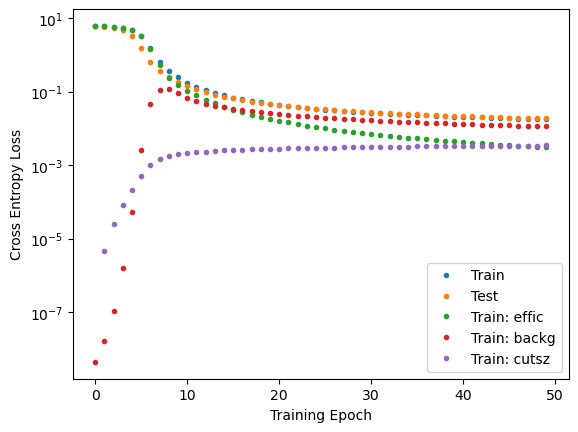

Signal Efficiency with net outputs: 80.1%
Background Efficiency with net outputs: 0.07526%
Parameter containing:
tensor([1.7099, 2.3000, 1.8860, 1.3644, 2.9159, 2.1203, 1.0207, 1.3746, 0.1985,
        2.2100], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.8, subnet_effic=0.7816831469535828, efficloss=0.0033550753723829985
Completed epoch  0 in  0.7s, Train loss=7.9e+00, Test loss=7.8e+00
Completed epoch  1 in  0.7s, Train loss=7.8e+00, Test loss=7.5e+00
Completed epoch  2 in  0.7s, Train loss=7.5e+00, Test loss=6.8e+00
Completed epoch  3 in  0.7s, Train loss=6.9e+00, Test loss=5.5e+00
Completed epoch  4 in  0.5s, Train loss=5.6e+00, Test loss=3.2e+00
Completed epoch  5 in  0.7s, Train loss=3.3e+00, Test loss=1.3e+00
Completed epoch  6 in  0.7s, Train loss=1.3e+00, Test loss=6.9e-01
Completed epoch  7 in  0.7s, Train loss=6.8e-01, Test loss=4.7e-01
Completed epoch  8 in  0.7s, Train loss=4.6e-01, Test loss=3.5e-01
Completed epoch  9 in  0.7s, Train loss=3.4e-01, T

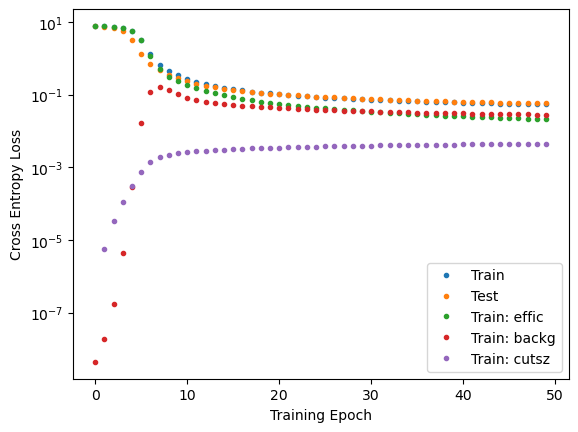

Signal Efficiency with net outputs: 86.8%
Background Efficiency with net outputs: 0.72755%
Parameter containing:
tensor([1.8816, 2.6911, 2.2169, 1.5614, 3.3380, 2.4241, 1.0904, 1.4490, 0.3152,
        2.5861], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.9, subnet_effic=0.8511805534362793, efficloss=0.02383336052298546


In [32]:
net.load_state_dict(torch.load('net_learningbiases_effictarget_prepretraining.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

pretrain_epochs=50
for efficnet,effic in zip(net.nets,net.effics):
    losses = []
    losses_test = []
    for epoch in range(pretrain_epochs):
        efficnet.train()
        start_time = time.time()
        for x_batch, y_batch in loader:
            y_pred = efficnet(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch, m, efficnet, effic, alpha, beta, gamma)
            loss.totalloss().backward()
            optimizer.step()
        losses.append(loss)
        efficnet.eval() # configure the model for evaluation (testing)
        y_pred = efficnet(x_test_tensor)
        test_loss = loss_fn(y_pred, y_test_tensor, m, efficnet, effic, alpha, beta, gamma)
        losses_test.append(test_loss)
        end_time=time.time()
        elapsed_time = end_time - start_time
        print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")
    LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)
    plt.show()
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, efficnet)
    print(efficnet.bias)

    # now debug the loss:
    final_loss = loss_fn(y_pred, y_test_tensor, m, efficnet, effic, alpha, beta, gamma, True)

In [33]:
# need to store the cuts
torch.save(net.state_dict(), 'net_learningbiases_effictarget_pretrained.pth')

# take a snapshot of the performance
for i in range(len(net.nets)):
    net.nets[i].eval()
    y_pred = net.nets[i](x_test_tensor)
    loss_fn(y_pred, y_test_tensor, m, net.nets[i], net.effics[i], alpha, beta, gamma, True)
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[i])

Inspecting efficiency loss: alpha=10.0, target=0.6, subnet_effic=0.5954172611236572, efficloss=0.0002100171404890716
Signal Efficiency with net outputs: 62.2%
Background Efficiency with net outputs: 0.00000%
Inspecting efficiency loss: alpha=10.0, target=0.7, subnet_effic=0.6918326020240784, efficloss=0.0006670620059594512
Signal Efficiency with net outputs: 71.2%
Background Efficiency with net outputs: 0.00000%
Inspecting efficiency loss: alpha=10.0, target=0.8, subnet_effic=0.7816831469535828, efficloss=0.0033550753723829985
Signal Efficiency with net outputs: 80.1%
Background Efficiency with net outputs: 0.07526%
Inspecting efficiency loss: alpha=10.0, target=0.9, subnet_effic=0.8511805534362793, efficloss=0.02383336052298546
Signal Efficiency with net outputs: 86.8%
Background Efficiency with net outputs: 0.72755%


Now start from the pre-trained weights and train the global model

In [34]:
net.load_state_dict(torch.load('net_learningbiases_effictarget_pretrained.pth',weights_only=True))

# check that after reloading the weights we still get the same performance after pretraining
net.eval() # configure the model for evaluation (testing)
y_pred = net(x_test_tensor)
test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon,True)

Inspecting efficiency loss: alpha=10.0, target=0.6, subnet_effic=0.5954172611236572, efficloss=0.0002100171404890716
Inspecting efficiency loss: alpha=10.0, target=0.7, subnet_effic=0.6918326020240784, efficloss=0.0006670620059594512
Inspecting efficiency loss: alpha=10.0, target=0.8, subnet_effic=0.7816831469535828, efficloss=0.0033550753723829985
Inspecting efficiency loss: alpha=10.0, target=0.9, subnet_effic=0.8511805534362793, efficloss=0.02383336052298546


In [35]:
losses = []
losses_test = []

pretrained_epochs=50

for epoch in range(pretrained_epochs):
    net.train()
    start_effics=[LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[i],False)[0] for i in range(len(net.nets))]
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon, False)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    end_effics=[LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[i],False)[0] for i in range(len(net.nets))]
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.7s, Train loss=8.6e-02, Test loss=9.1e-02
Completed epoch  1 in  0.8s, Train loss=8.5e-02, Test loss=9.0e-02
Completed epoch  2 in  0.7s, Train loss=8.4e-02, Test loss=8.9e-02
Completed epoch  3 in  0.6s, Train loss=8.3e-02, Test loss=8.8e-02
Completed epoch  4 in  0.8s, Train loss=8.2e-02, Test loss=8.8e-02
Completed epoch  5 in  0.9s, Train loss=8.2e-02, Test loss=8.7e-02
Completed epoch  6 in  0.9s, Train loss=8.1e-02, Test loss=8.6e-02
Completed epoch  7 in  0.7s, Train loss=8.0e-02, Test loss=8.5e-02
Completed epoch  8 in  0.8s, Train loss=8.0e-02, Test loss=8.5e-02
Completed epoch  9 in  0.8s, Train loss=7.9e-02, Test loss=8.4e-02
Completed epoch 10 in  0.8s, Train loss=7.8e-02, Test loss=8.3e-02
Completed epoch 11 in  0.7s, Train loss=7.8e-02, Test loss=8.3e-02
Completed epoch 12 in  0.7s, Train loss=7.7e-02, Test loss=8.2e-02
Completed epoch 13 in  0.8s, Train loss=7.7e-02, Test loss=8.2e-02
Completed epoch 14 in  0.6s, Train loss=7.6e-02, Test loss=8.1

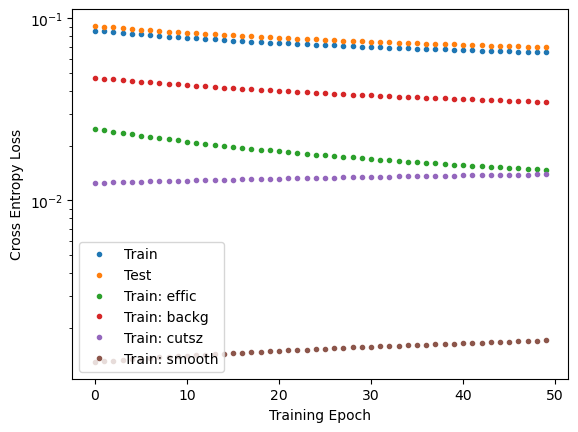

In [36]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

In [37]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[n])

Target efficiency: 60.0%
Signal Efficiency with net outputs: 62.8%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 71.5%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 80.9%
Background Efficiency with net outputs: 0.02509%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 87.5%
Background Efficiency with net outputs: 0.45158%


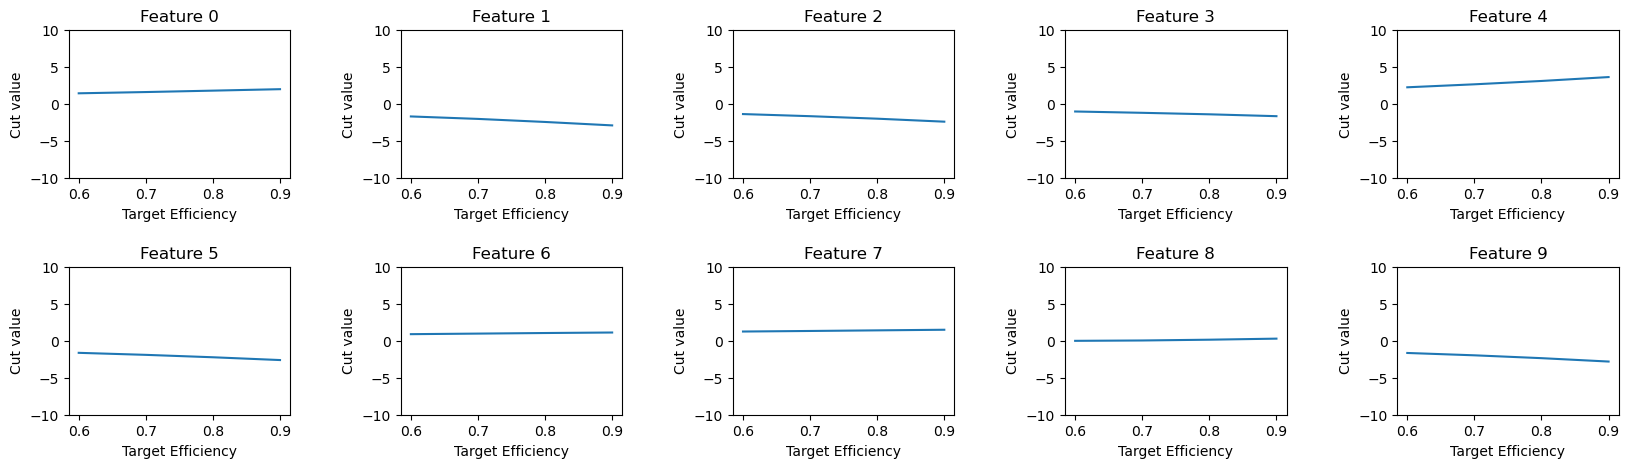

In [38]:
LearningCutsUtils.LearningCutsUtils.plotcuts(net)

Target efficiency: 60.0%


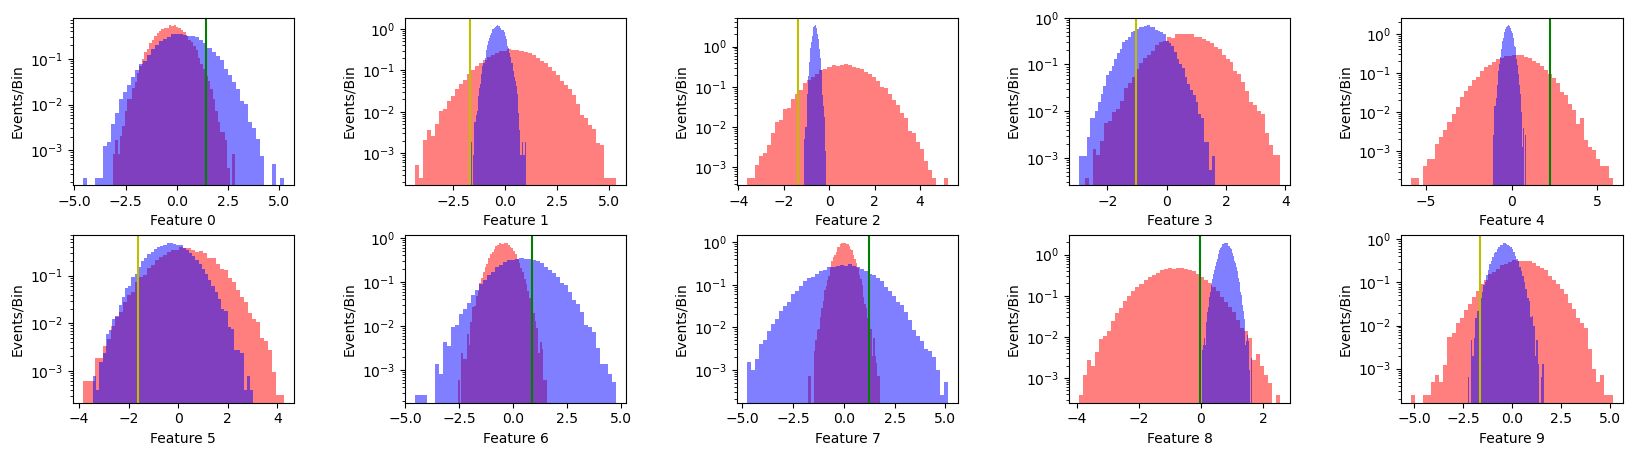

Target efficiency: 70.0%


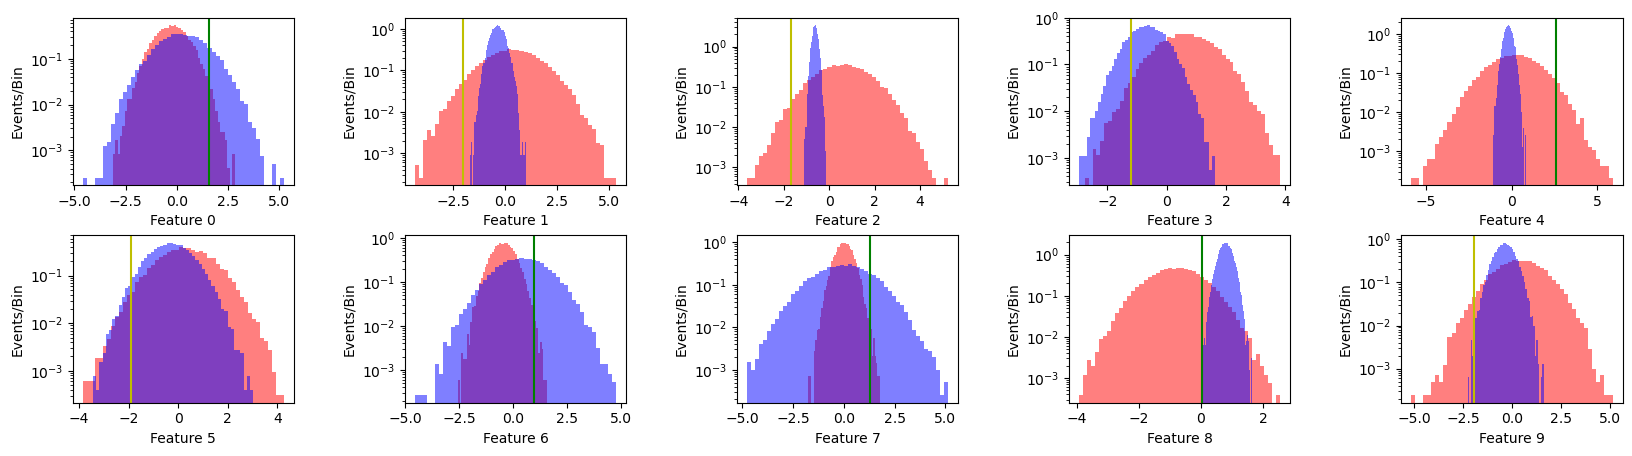

Target efficiency: 80.0%


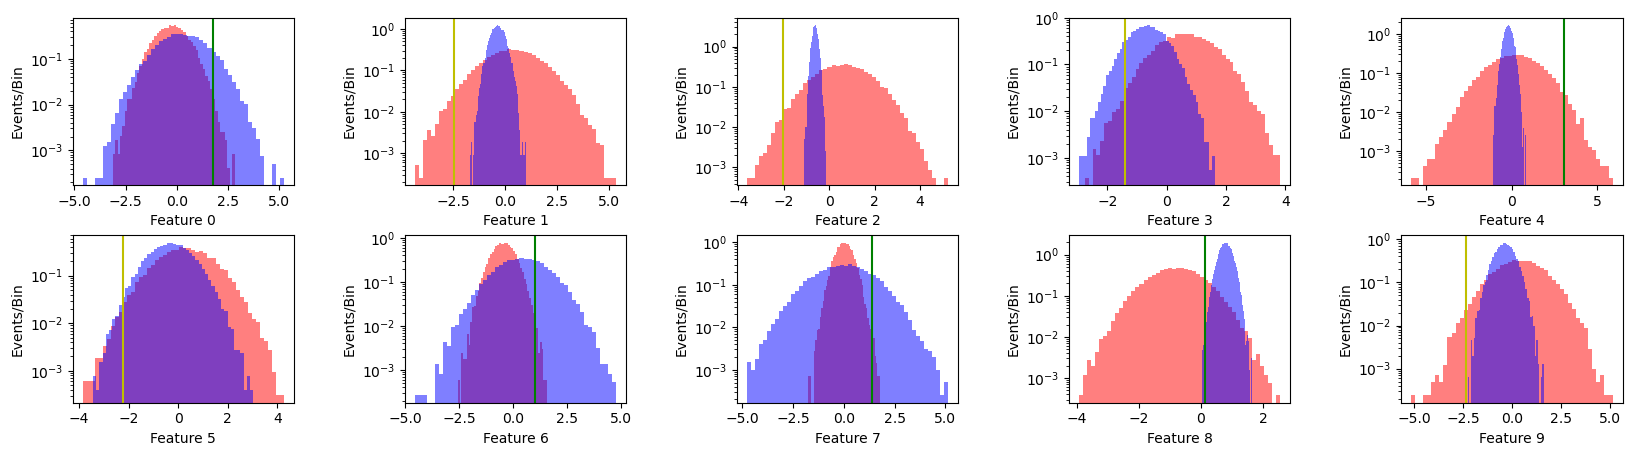

Target efficiency: 90.0%


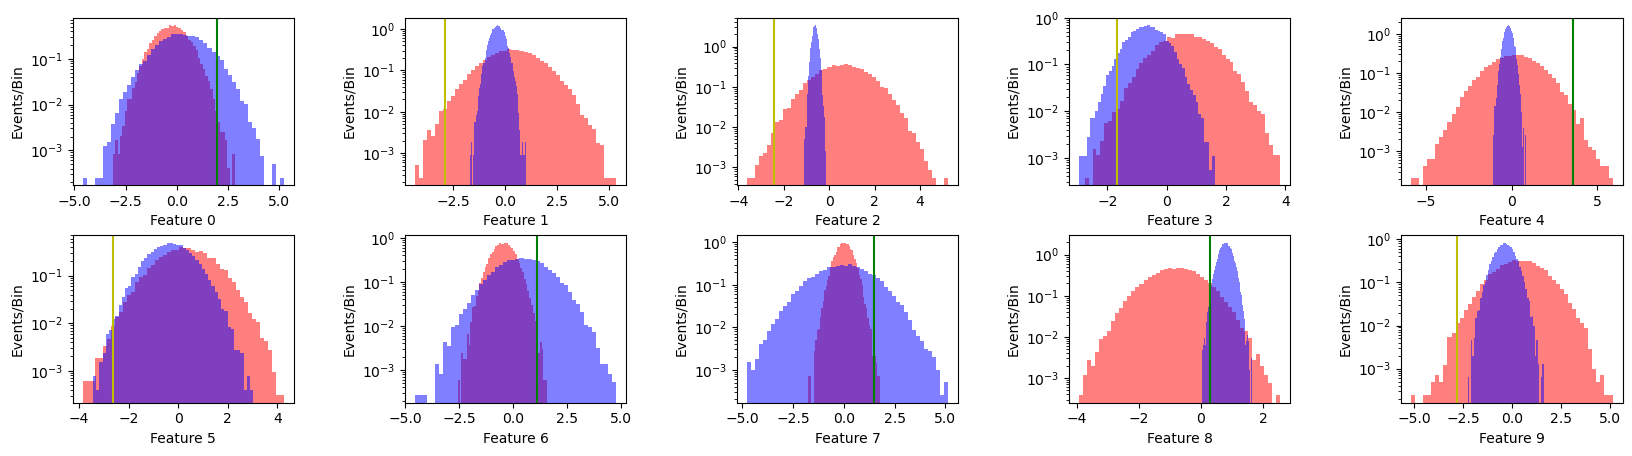

In [39]:
LearningCutsUtils.LearningCutsUtils.plotfeatures(net,x_signal,x_backgr,sc)

Looks like pretraining for efficiency doesn't really help at all, relative to just training all in one go.